In [1]:
import numpy as np

import cv2

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from scipy.ndimage.measurements import label

import pickle

import glob

from random import shuffle

import os

import time

import math

from tqdm import tqdm

from moviepy.editor import VideoFileClip

In [16]:
!pwd

/home/ashis/ashis/Udacity/SDC/Term_1/Project_5/CarND-Vehicle-Detection


In [ ]:
os.chdir('.')

### Load  vehicle and Non vehicle dataset for training

In [44]:
veh_far = glob.glob('../vehicles/vehicles/GTI_Far/image*.png')
veh_left = glob.glob('../vehicles/vehicles/GTI_Left/image*.png')
veh_middle = glob.glob('../vehicles/vehicles/GTI_MiddleClose/image*.png')
veh_right = glob.glob('../vehicles/vehicles/GTI_Right/image*.png')
veh = veh_far + veh_left + veh_middle + veh_right
shuffle(veh)

not_veh_extras = glob.glob('../non-vehicles/non-vehicles/Extras/extra*.png')
not_veh_gti = glob.glob('../non-vehicles/non-vehicles/GTI/image*.png')
not_veh = not_veh_extras + not_veh_gti
shuffle(not_veh)


Total Number of Vehicle Images: 2826
Total Number of Non-Vehicle Images: 8968
Image Size: (64, 64, 3)
Image Type: float32


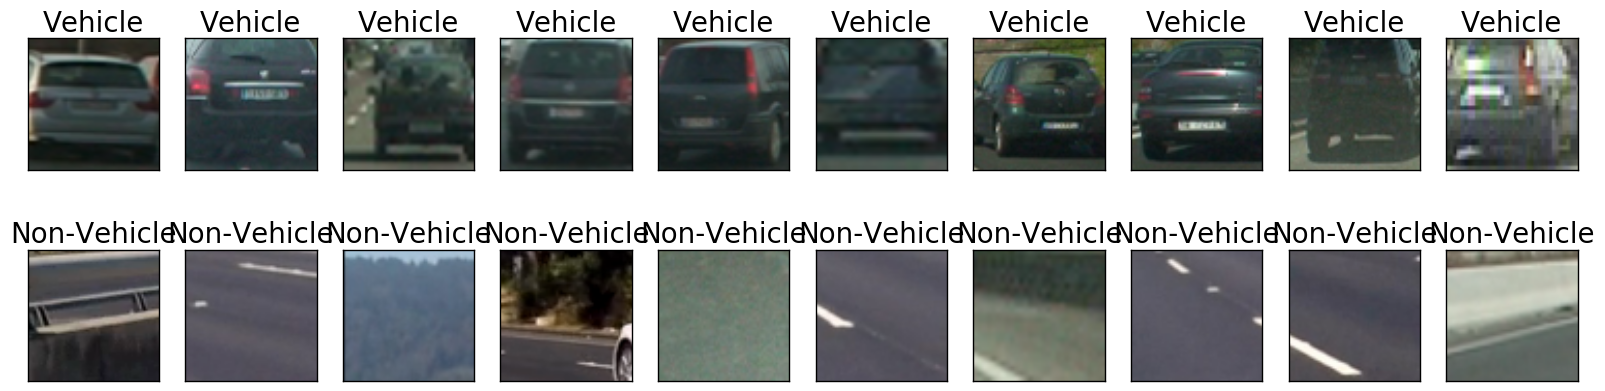

In [45]:
def visualize_data(cars, not_cars):
    data_dict = {}
    data_dict["n_cars"] = len(cars)
    data_dict["n_not_cars"] = len(not_cars)
    img = mpimg.imread(cars[0])
    data_dict["img_shape"] = img.shape
    data_dict["d_type"] = img.dtype
    return data_dict

visual = visualize_data(veh, not_veh)  

print('Total Number of Vehicle Images: {0}'.format(visual['n_cars']))
print('Total Number of Non-Vehicle Images: {0}'.format(visual['n_not_cars']))

print('Image Size: {0}\nImage Type: {1}'.format(visual['img_shape'], visual['d_type']))

def random_image(cars, not_cars):
    car_id = np.random.randint(0, len(cars))
    not_car_id = np.random.randint(0, len(not_cars))
    car_image = mpimg.imread(cars[car_id])
    not_car_image = mpimg.imread(not_cars[not_car_id])
    return car_image, not_car_image

n = 0
fig = plt.figure(figsize=(20, 10))
while n < 10:
    car_image, not_car_image = random_image(cars, not_cars)
    fig.add_subplot(1, 10, n+1)
    plt.imshow(not_car_image)
    plt.xticks(()); 
    plt.yticks(());    
    plt.title('Non-Vehicle', fontsize=20)
    fig.add_subplot(2, 10, n+1)
    plt.imshow(car_image)
    plt.xticks(()); plt.yticks(());    
    plt.title('Vehicle', fontsize=20)
    n += 1
plt.savefig('output_images/veh_non_veh_visualization.png', bbox_inches="tight")

#### Histogram of color  visualization 

In [46]:
car_id = np.random.randint(0, len(veh))
print ('car_id ',car_id)
car_id = np.random.randint(0, len(veh))
rand_img = cv2.imread(veh[car_id])
rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)
rand_img.shape

car_id  1819


(64, 64, 3)

In [36]:
green_hist
bin_centers

array([   4.,   12.,   20.,   28.,   36.,   44.,   52.,   60.,   68.,
         76.,   84.,   92.,  100.,  108.,  116.,  124.,  132.,  140.,
        148.,  156.,  164.,  172.,  180.,  188.,  196.,  204.,  212.,
        220.,  228.,  236.,  244.,  252.])

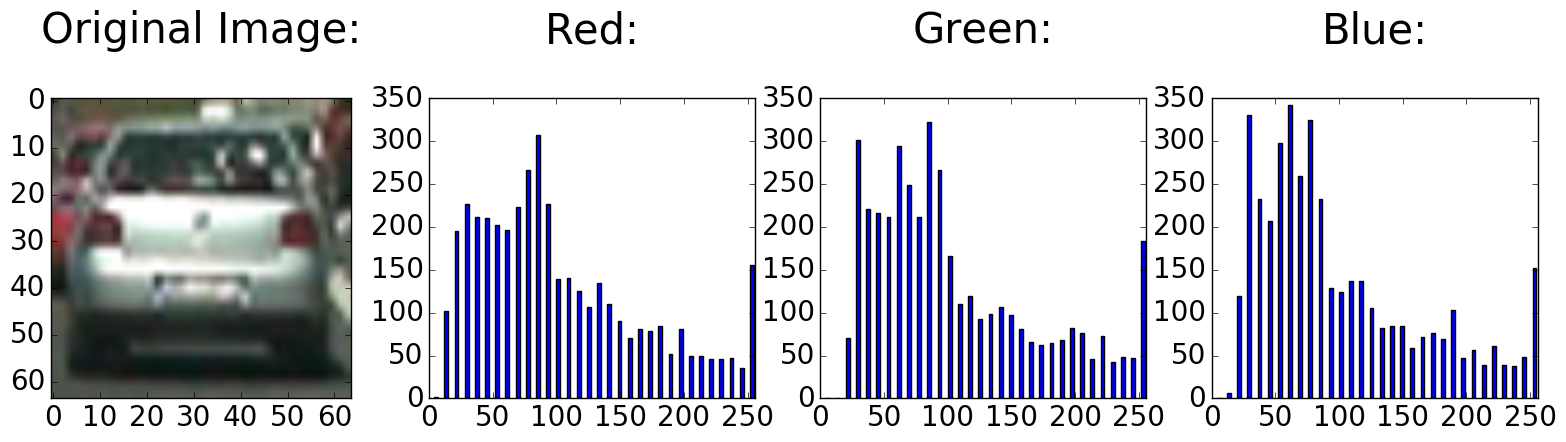

In [33]:
red_hist = np.histogram(rand_img[:,:,0], bins=32, range=(0, 256))
green_hist = np.histogram(rand_img[:,:,1], bins=32, range=(0, 256))
blue_hist = np.histogram(rand_img[:,:,2], bins=32, range=(0, 256))
hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]))

bin_edges = red_hist[1] #all three bins are the same size
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2

fig = plt.figure(figsize=(10,3));
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

plt.subplot(1, 4, 1)
plt.imshow(rand_img)
plt.title('Original Image:\n', fontsize=30);

plt.subplot(1, 4, 2)
plt.bar(bin_centers, red_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Red:\n', fontsize=30);

plt.subplot(1, 4, 3)
plt.bar(bin_centers, green_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Green:\n', fontsize=30);

plt.subplot(1, 4, 4)
plt.bar(bin_centers, blue_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Blue:\n', fontsize=30);

plt.subplots_adjust(left=0.5, right=2, top=1, bottom=0.)
plt.savefig('output_images/histograms_color_visualization.png', 
            bbox_inches="tight")

#### Color Distribution Visualization

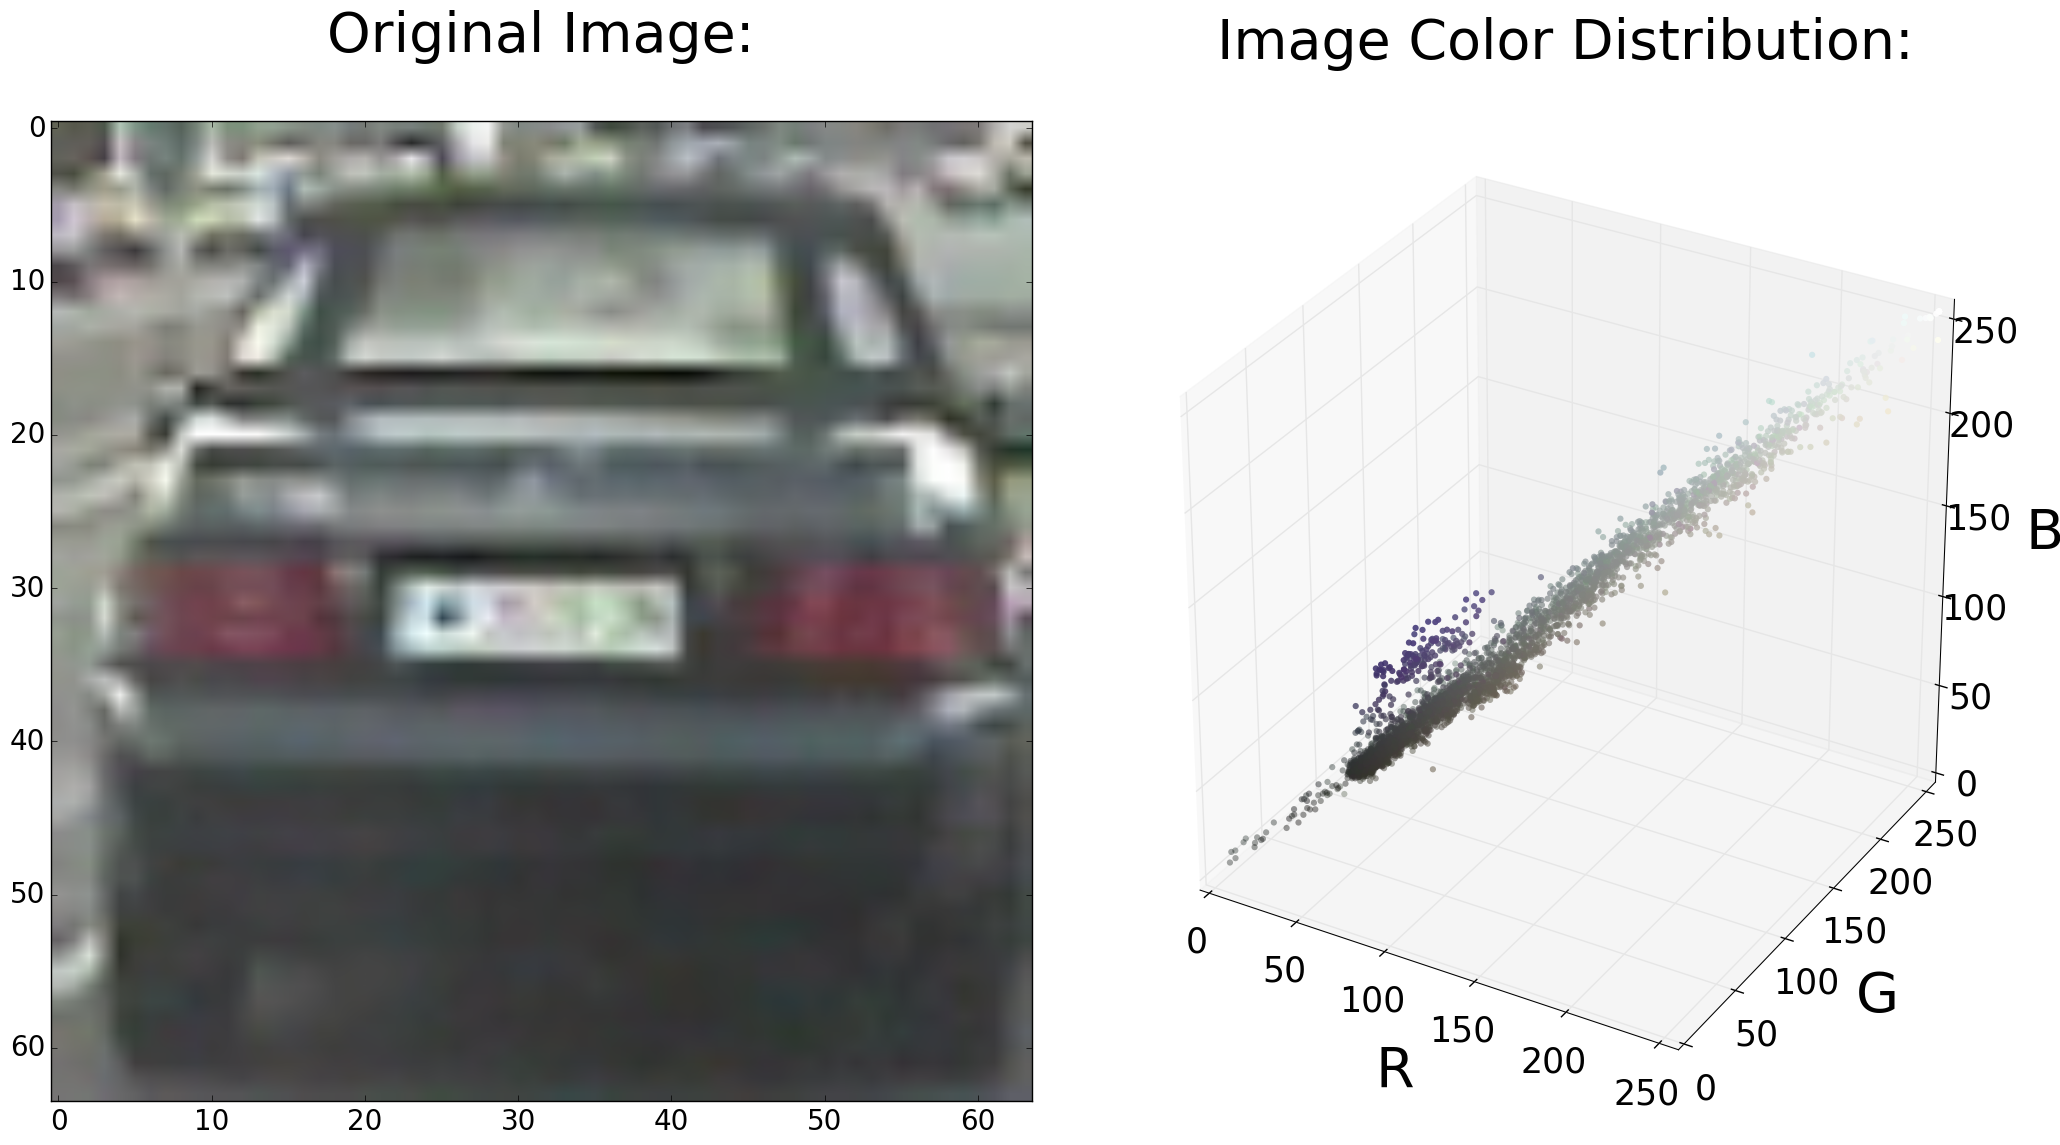

In [47]:
scale = max(rand_img.shape[0], rand_img.shape[1], 64) / 64
img_small = cv2.resize(rand_img, (np.int(rand_img.shape[1] / scale),
                                  np.int(rand_img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.

pixels = img_small_RGB
colors_rgb = img_small_rgb
axis_labels = list('RGB')
axis_limits = [(0,255), (0,255), (0,255)]

f = plt.figure(figsize=(20,10));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=40);

ax2 = f.add_subplot(1, 2, 2, projection='3d');
ax2.text2D(0.15, 0.99, "Image Color Distribution:\n", 
           transform=ax2.transAxes, fontsize=40)

ax2.set_xlim(*axis_limits[0])
ax2.set_ylim(*axis_limits[1])
ax2.set_zlim(*axis_limits[2])

ax2.tick_params(axis='both', which='major', labelsize=25, pad=8)
ax2.set_xlabel(axis_labels[0], fontsize=40, labelpad=30)
ax2.set_ylabel(axis_labels[1], fontsize=40, labelpad=30)
ax2.set_zlabel(axis_labels[2], fontsize=40, labelpad=30)

ax2.scatter(pixels[:,:,0].ravel(), pixels[:,:,1].ravel(), 
            pixels[:,:,2].ravel(), c=colors_rgb.reshape((-1, 3)), 
            edgecolors='none');

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/color_distribution_visualization.png', 
            bbox_inches="tight")

#### Spatial binning of color in image visualization

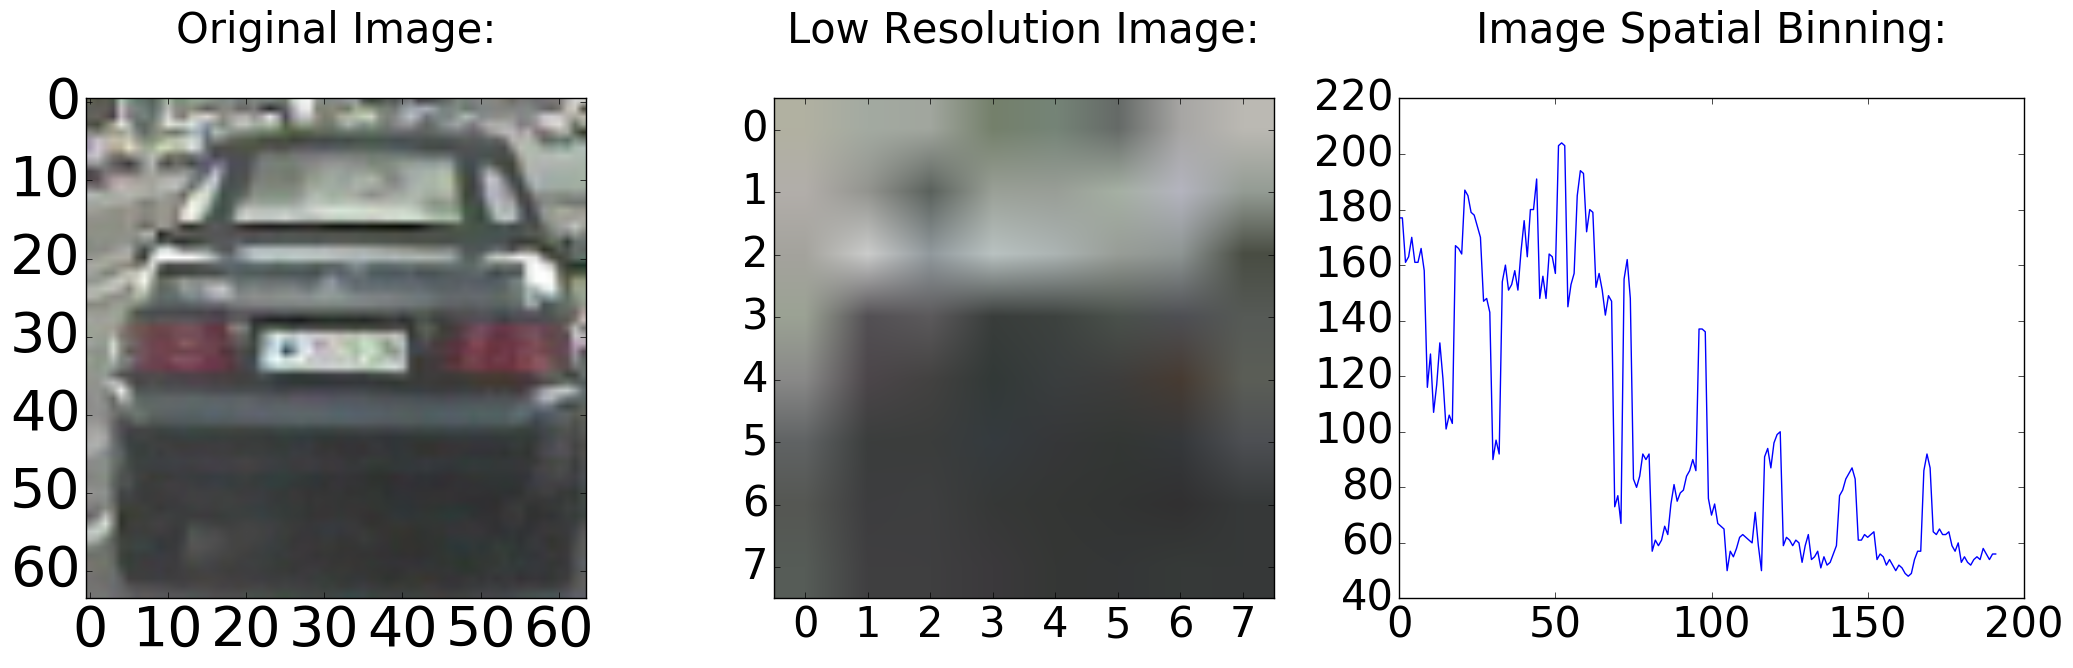

In [48]:
color_space = 'RGB'
size = (8, 8)

small_img = cv2.resize(rand_img, size)

if color_space != 'RGB':
    if color_space == 'HSV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2YCrCb)
else: 
    feature_img = np.copy(rand_img)             
features = cv2.resize(feature_img, size).ravel() 

f = plt.figure(figsize=(20, 5));
ax1 = f.add_subplot(1, 3, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=30);

ax2 = f.add_subplot(1, 3, 2);
ax2.imshow(small_img)
ax2.set_title('Low Resolution Image:\n', fontsize=30);

ax3 = f.add_subplot(1, 3, 3);
ax3.plot(features)
ax3.set_title('Image Spatial Binning:\n', fontsize=30);

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/spatial_binning_visualization.png', 
            bbox_inches="tight")

#### Visualization of  gradient features in an image

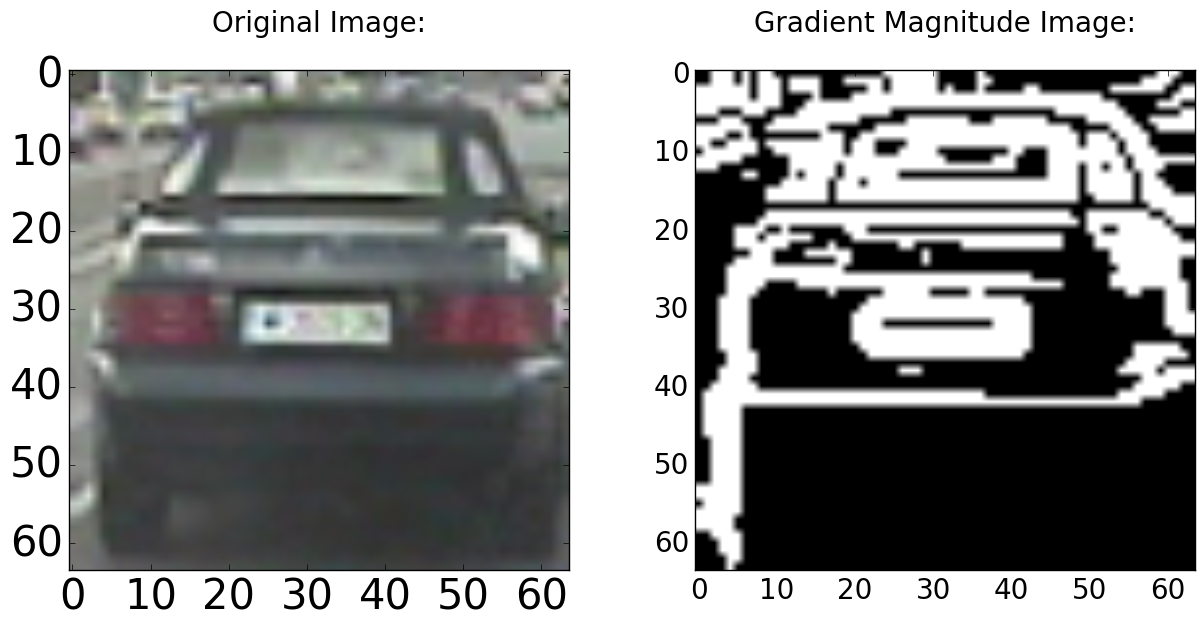

In [49]:
gray = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8) 
binary_output = np.zeros_like(gradmag)
binary_output[(gradmag >= 50) & (gradmag <= 255)] = 1

f = plt.figure(figsize=(12, 5));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=20);

ax2 = f.add_subplot(1, 2, 2);
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Gradient Magnitude Image:\n', fontsize=20);

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/gradient_visualization.png', bbox_inches="tight")

#### Visualization of HOG features in an image

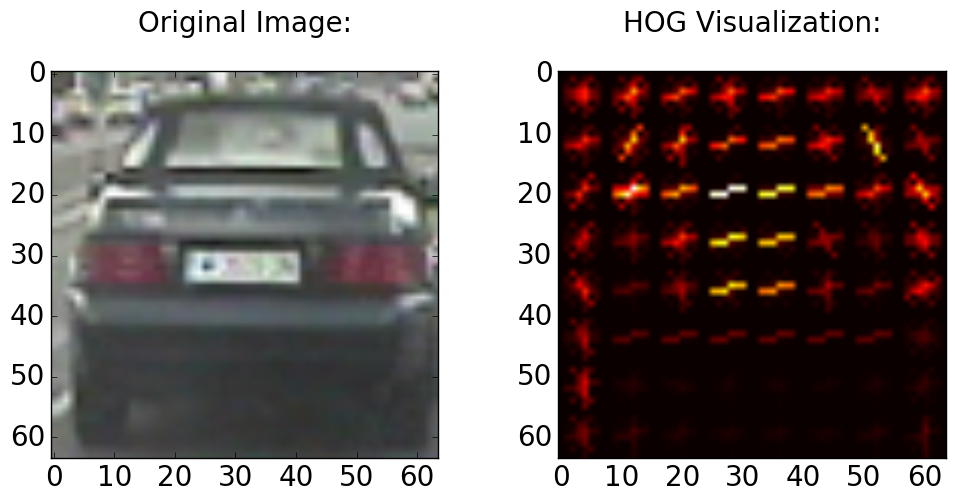

In [50]:
hog_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)

features, hog_image = hog(hog_img, 
                          orientations=9, 
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualise=True,
                          feature_vector=False)

fig = plt.figure(figsize=(12, 5));
fig.add_subplot(1, 2, 1)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.imshow(rand_img)
plt.title('Original Image:\n', fontsize=20);
fig.add_subplot(1, 2, 2)
plt.imshow(hog_image, cmap='hot')
plt.title('HOG Visualization:\n', fontsize=20);
plt.savefig('output_images/hog_visualization.png', bbox_inches="tight")

#### Combining all above feature extraction methods 

In [51]:
def get_color_histogram(img, n_bins=32, bins_range=(0, 256)):
    red_hist = np.histogram(img[:,:,0], bins=n_bins, range=bins_range)
    green_hist = np.histogram(img[:,:,1], bins=n_bins, range=bins_range)
    blue_hist = np.histogram(img[:,:,2], bins=n_bins, range=bins_range)
    bin_edges = red_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((red_hist[0], 
                                    green_hist[0], 
                                    blue_hist[0]))
    return red_hist, green_hist, blue_hist, bin_centers, hist_features

def get_3d_color_plot(pixels, colors_rgb,
                      axis_labels=list("RGB"),
                      axis_limits=[(0, 255), (0, 255), (0, 255)]):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)  
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax

def get_bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

def get_gradient_features(img, sobel_kernel=9, mag_threshold=(60, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & \
                  (gradmag <= mag_threshold[1])] = 1
    return binary_output

def get_hog_features(img, 
                     orientation=9, 
                     pixels_per_cell=(8,8), 
                     cells_per_block=(2,2), 
                     visualization=False, 
                     feature_vector=True):
    if visualization == True:
        features, hog_image = hog(img, orientations=orientation, 
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, 
                                  transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orientation, 
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, 
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector) 
        return features
    
def extract_features(images, color_space='RGB', 
                     spatial_size=(32,32), 
                     hist_bins=32, hist_range=(0,256),
                     orientations=9, pixels_per_cell=(8,8),
                     cells_per_block=(2,2), hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)      
        
        if spatial_feat == True:
            spatial_features = get_bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pixels_per_cell, 
                                                         cells_per_block, visualization=False,
                                                         feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orientations, pixels_per_cell,
                                                cells_per_block, visualization=False,
                                                feature_vector=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))      
    return features

#### Visualization of combined scaled features of an image 

100%|██████████| 8968/8968 [00:29<00:00, 306.75it/s]


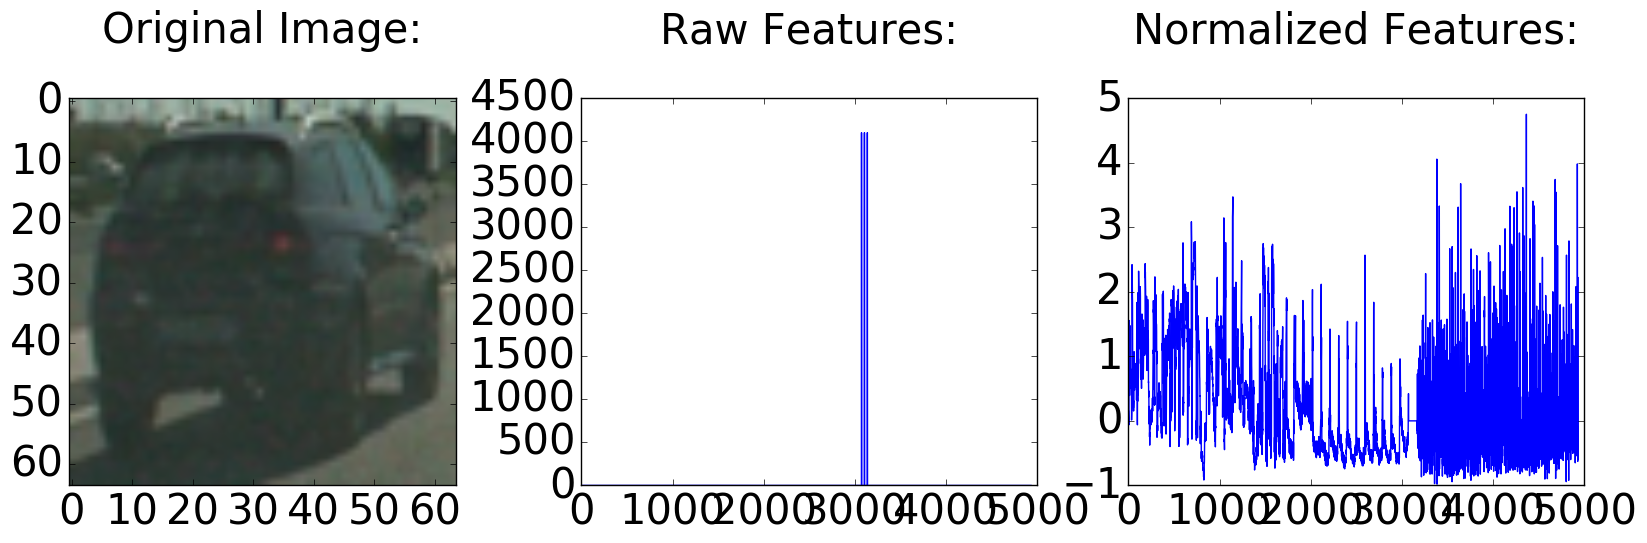

In [54]:
veh_features = extract_features(veh, spatial_feat=True, hist_feat=True)
not_veh_features = extract_features(not_veh, spatial_feat=True, hist_feat=True)

if len(car_features) > 0:
    X = np.vstack((car_features, not_car_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/color_classification.png')

else:
    print('Returned empty feature vectors.')

#### Preparing dataset for classification

In [55]:
X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

print (scaled_X.shape)
print (y.shape)

(11794, 4932)
(11794,)


In [57]:
rand_state = np.random.randint(0, 10)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,test_size=0.2,random_state=rand_state)
print ('X_train ',X_train.shape)

X_train  (9435, 4932)


#### Clssify using a linear SVC

In [58]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

19.73 seconds to train SVC.


In [59]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])

Test Accuracy: 97.7109%
  Predictions: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
       Labels: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


#### Classifying with HOG features

100%|██████████| 8968/8968 [02:05<00:00, 71.18it/s]


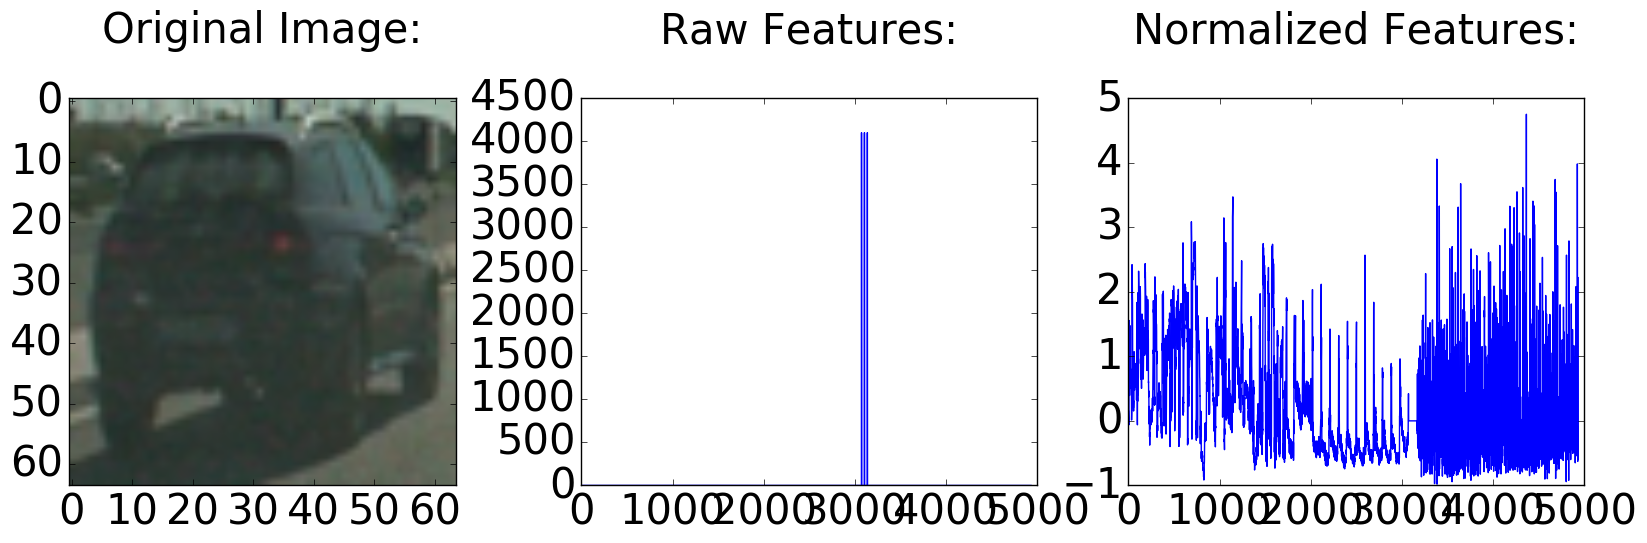

In [61]:
veh_features = extract_features(veh, hog_feat=True)
not_veh_features = extract_features(not_veh, hog_feat=True)

if len(veh_features) > 0:
    X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/hog_classification.png')

else:
    print('Returned empty feature vectors.')

In [62]:
y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [63]:
rand_state = np.random.randint(0, 10)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)


In [64]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

19.9 seconds to train SVC.


In [65]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy: 97.6261%
  Predictions: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
       Labels: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
0.19744 seconds to predict 10 labels with SVC.


### Search Vehicles in images

#### Sliding window approach to figure out vehicles in an image

In [68]:
def draw_boxes(img, bboxes, color=(0,0,255), thickness=6):
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], 
                      color, thickness)
    return img_copy

def sliding_windows(img, x_start_stop=[None,None], 
                    y_start_stop=[None,None], xy_window=(64,64),
                    xy_overlap=(0.5,0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*0.5)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*0.9)
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


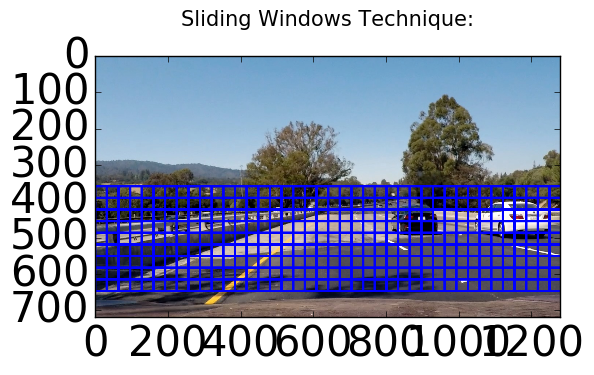

In [69]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  sliding_windows(test_img)

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:\n', fontsize=15);
plt.savefig('output_images/sliding_windows_test4.png')

#### Apply trained classifier to search for vehicles in sliding-window images

In [ ]:
def single_img_features(img, color_space='RGB', 
                        spatial_size=(64,64), hist_bins=64, 
                        orientations=9, pixels_per_cell=(8,8), 
                        cells_per_block=(2,2), hog_channel=0, 
                        spatial_feat=True, hist_feat=True, 
                        hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    if spatial_feat == True:
        spatial_features = get_bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orientations, pixels_per_cell,
                                                     cells_per_block, 
                                                     visualization=False,
                                                     feature_vector=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orientations, pixels_per_cell,
                                            cells_per_block, visualization=False,
                                            feature_vector=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

def search_windows(img, windows, svc, scaler, 
                   color_space='RGB', spatial_size=(64,64), 
                   hist_bins=64, hist_range=(0,256), orientations=9,
                   pixels_per_cell=(8,8), cells_per_block=(2,2),
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orientations=orientations, pixels_per_cell=pixels_per_cell, 
                            cells_per_block=cells_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = svc.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 9  # HOG orientations
pixels_per_cell = (16,16) # HOG pixels per cell
cells_per_block = (4,4) # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
not_car_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

print('Using:', orientations, 'orientations', pixels_per_cell,
    'pixels per cell and', cells_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), ' seconds to train SVC.')
print('Test Accuracy of SVC: {0}%'.format(round(svc.score(X_test, y_test)*100, 4)))
t=time.time()

img = mpimg.imread('test_images/test4.jpg')
draw_img = np.copy(img)

# Training Data extracted from .png images (scaled 0 to 1 by mpimg)
# Search image is a .jpg (scaled 0 to 255)
img = img.astype(np.float32)/255

windows = sliding_windows(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_img, hot_windows)                    

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);

bbox_pickle = {}
all_bboxes = hot_windows
bbox_pickle["bboxes"] = all_bboxes
pickle.dump(bbox_pickle, open("output_images/bbox_pickle.p", "wb"));

plt.savefig('output_images/all_window_detections.png')

#### Apply heat map to remove false positive from frames

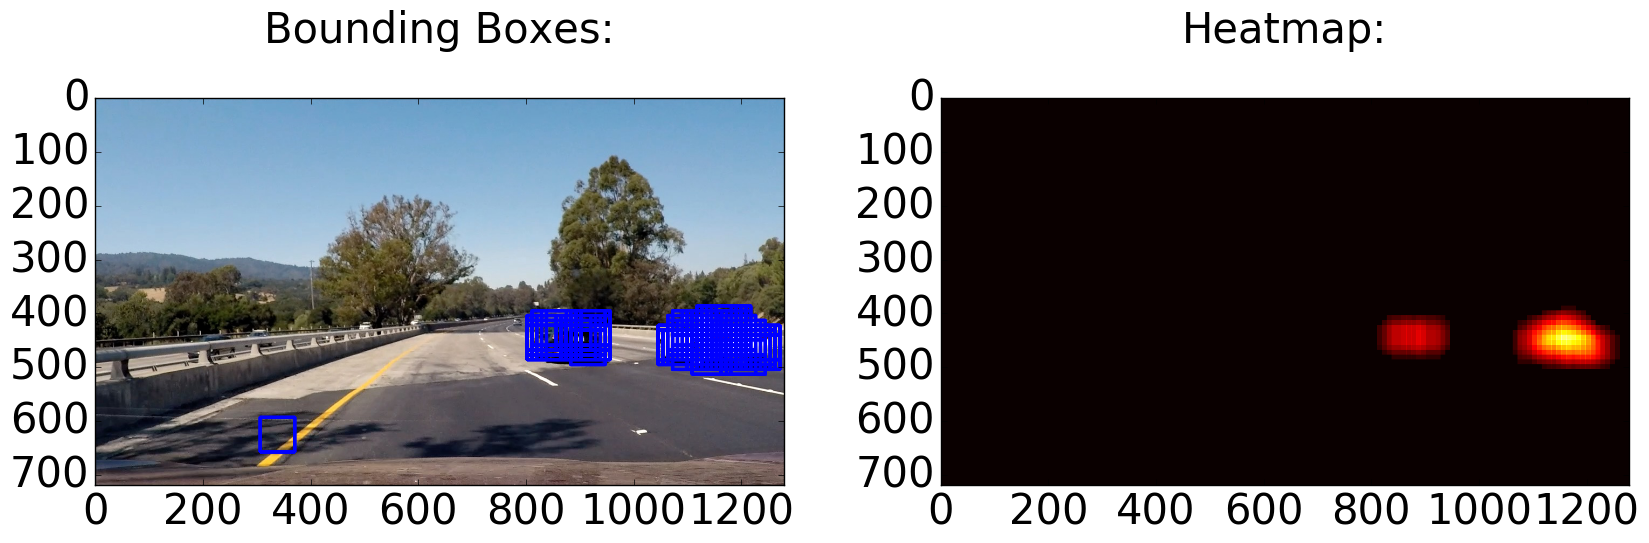

In [72]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
 
def apply_heat_threshold(heatmap, threshold=4):
    heatmap[heatmap <= threshold] = 0
    return heatmap

bbdict = pickle.load( open( "output_images/bbox_pickle.p", "rb" ))
all_bboxes = bbox_pickle["bboxes"]

img = mpimg.imread('test_images/test4.jpg')
#img = undistort(img)
heatmap = np.zeros_like(img[:,:,0].astype(np.float))

heatmap = add_heat(heatmap, all_bboxes)
heatmap = apply_heat_threshold(heatmap)
heatmap = np.clip(heatmap-2, 0, 255)

labels = label(heatmap)

#print('Cars Found: {0}'.format(labels[1]))

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap:\n', fontsize=30);
plt.savefig('output_images/heatmap.png')

#### Bounding box Estimation

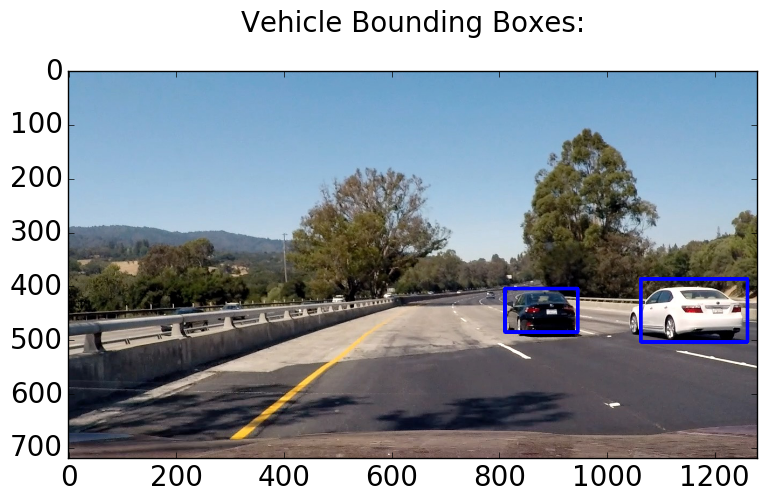

In [73]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img = mpimg.imread('test_images/test4.jpg')
draw_img = np.copy(img)
draw_img = draw_labeled_bboxes(draw_img, labels)

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.imshow(draw_img)
plt.title('Vehicle Bounding Boxes:\n', fontsize=20);

In [74]:
def BGRtoYUV(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

orientations = 8
pixels_per_cell = 8
cells_per_block = 2

def hog_features(channel, visualise=False):
    if visualise == True:
        features, hog_image = hog(channel, orientations=orientations,
                                  pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return hog_image
    else:      
        features = hog(channel, orientations=orientations,
                       pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

def derive_features(img):
    img = BGRtoYUV(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

In [76]:
input_images = []
y = []

for filename in tqdm(glob.glob(('../vehicles/vehicles/*/*.png'))):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(True)

for filename in tqdm(glob.glob('../non-vehicles/non-vehicles/*/*.png')):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(False)
    
len(input_images)

100%|██████████| 8968/8968 [01:02<00:00, 142.84it/s]


17760

In [77]:
X_scaler = StandardScaler().fit(input_images)
input_images = X_scaler.transform(input_images)

X_train, X_test, y_train, y_test = train_test_split(input_images, y, test_size=0.2, stratify=y, random_state=1)

classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))

Vehicle classifier trained with test accuracy: 98.8%


In [79]:
WINDOW_SIZES = [(64, 64), (96, 96), (128, 128)]
WINDOW_Y_START_STOP = [(400, 500), (400, 500), (400, 500)]
WINDOW_OVERLAP = (0.8, 0.8)

# img is of RGB type
def slide_window(img):
    window_list = []
    
    for (xy_window, y_start_stop) in zip(WINDOW_SIZES, WINDOW_Y_START_STOP):
        x_start = int(img.shape[1]/2)
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        # Compute ROI.
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        # Compute the step between successive windows.
        nx_pix_per_step = np.int(xy_window[0] * (1. - WINDOW_OVERLAP[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - WINDOW_OVERLAP[1]))
        # Compute the number of windows to generate at this size.
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        # Loop through the x and y positions to find the window coordinates.
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows.
    return window_list

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
img = draw_boxes(img, windows)

In [80]:
threshold = 0.8

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
img = draw_boxes(img, windows)

In [81]:
HEATMAP_THRESHOLD = 4

def add_heat(heatmap, bboxes):
    # Iterate through each bbox.
    for bbox in bboxes:
        # Add +1 for all pixels inside each bbox.
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap.
    return heatmap
    
def apply_threshold(heatmap):
    # Zero out pixels below the threshold.
    heatmap[heatmap <= HEATMAP_THRESHOLD] = 0
    # Return thresholded map.
    return heatmap

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)

In [82]:
def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    labels = label(heatmap)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
img = draw_labeled_bboxes(img, heatmap)

In [83]:
frame_count = 5

class VehicleDetector:
    def __init__(self):
        self.bboxes = []
    
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-frame_count:]
    
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        return heatmap

In [84]:
def video_pipeline(img, vehicle_detector=None):
    if vehicle_detector is None:
        vehicle_detector = VehicleDetector()
    windows = slide_window(img)
    windows = search_windows(img, windows, classifier, X_scaler)
    vehicle_detector.add_bboxes(windows)
    heatmap = vehicle_detector.heatmap()
    img = draw_labeled_bboxes(img, heatmap)
    return img

In [85]:
video_output = 'P5_test_video.mp4'
clip = VideoFileClip('test_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video P5_test_video.mp4
[MoviePy] Writing video P5_test_video.mp4


 97%|█████████▋| 38/39 [02:51<00:04,  4.66s/it]      | 1/39 [00:02<01:45,  2.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_test_video.mp4 

CPU times: user 5min 37s, sys: 4.28 s, total: 5min 42s
Wall time: 2min 54s


In [ ]:
video_output = 'P5_project_video_final.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video P5_project_video_final.mp4
[MoviePy] Writing video P5_project_video_final.mp4


 75%|███████▌  | 951/1261 [1:24:50<37:47,  7.32s/it]   | 1/1261 [00:03<1:11:12,  3.39s/it]